# Compute cluster enrichments and correlations

In [4]:
import pandas as pd

conditions = ['WT', 'KO']
stringencies = ['normal', 'stringent']

embeddings = {}
for condition in conditions:
    condition_data = {}
    for stringency in stringencies:
        key = f'{stringency}_{condition}'
        condition_data[stringency] = pd.read_hdf(
            f'../embeddings_genome_lap2enriched.h5',
            key
        )

    embeddings[condition] = condition_data

conditions = ['WT', 'KO']
embeddings['WT']['normal']

UMAP1     UMAP2 louvain_0.05 louvain_0.1 louvain_0.15  \
BIN_481440  13.387651  1.891821            0           1            2   
BIN_481431  13.377353  1.891822            0           1            2   
BIN_104648  13.381000  1.935919            0           1            2   
BIN_326529  13.218095  2.538273            0           1            2   
BIN_481439  13.350541  0.426501            0           1            2   
...               ...       ...          ...         ...          ...   
BIN_106148  -4.245110 -0.889903            1           0            4   
BIN_320057   2.101333  7.539948            1           0            1   
BIN_240577  10.058013  6.615355            0           1            0   
BIN_117788  -0.232760 -1.431789            1           0            4   
BIN_371710  12.629237  0.221098            0           1            2   

           louvain_0.2 chromhmm_5 chromhmm_6 chromhmm_7 chromhmm_8  ...  \
BIN_481440           2         E5         E5         E3         E6  ...   
BIN_481431           2         E5         E5         E3         E6  ...   
BIN_104648           2         E5         E5         E3         E6  ...   
BIN_326529           2         E5         E5         E3         E6  ...   
BIN_481439           2         E5         E5         E3         E6  ...   
...                ...        ...        ...        ...        ...  ...   
BIN_106148           0         E2         E2         E6         E2  ...   
BIN_320057           4         E4         E4         E2         E7  ...   
BIN_240577           1         E4         E4         E2         E7  ...   
BIN_117788           0         E2         E2         E6         E2  ...   
BIN_371710           0         E5         E5         E3         E5  ...   

           chipseq_CHD4_WT_16 chipseq_CHD4_WT_20  chipseq_laminA_3A6_WT_16  \
BIN_481440          42.882882          40.847828                  0.000000   
BIN_481431          30.297809          28.231758                  0.000000   
BIN_104648          26.447991          20.758425                  0.000000   
BIN_326529          12.110506           9.660150                  0.320720   
BIN_481439          23.880168          22.131034                  0.000000   
...                       ...                ...                       ...   
BIN_106148           0.340845           0.000000                  2.516178   
BIN_320057           0.000000           0.000000                  0.188768   
BIN_240577           0.000000           0.000000                  0.000000   
BIN_117788           1.340080           0.000000                  1.827287   
BIN_371710           4.179813           2.682514                  0.000000   

            chipseq_laminA_3A6_WT_20  chipseq_laminA_E1_WT_16  \
BIN_481440                  0.801821                 2.150951   
BIN_481431                  0.000000                 3.821869   
BIN_104648                  0.264631                 3.878611   
BIN_326529                  0.000000                 3.123011   
BIN_481439                  0.000000                 2.693376   
...                              ...                      ...   
BIN_106148                  2.012445                 1.471659   
BIN_320057                  0.307201                 0.273263   
BIN_240577                  0.000000                 0.000000   
BIN_117788                  0.881227                 1.528401   
BIN_371710                  0.000000                 0.052702   

            chipseq_laminA_E1_WT_20  chipseq_LAP2alpha_WT_16  \
BIN_481440                 2.424888               230.338828   
BIN_481431                 1.760015               144.734697   
BIN_104648                 2.631438               111.289926   
BIN_326529                 0.000000                37.825578   
BIN_481439                 0.000000                52.559598   
...                             ...                      ...   
BIN_106148                 2.108138                 1.197120   
BIN_3200

In [5]:
from laminatools import vectorize
import numpy as np


ordered_data_columns = {
    'WT': [
        'rnaseq_WT',
        'atacseq_WT',
        'chipseq_BRG1_WT_16',
        'chipseq_BRG1_WT_20', 
        'chipseq_CHD4_WT_16', 
        'chipseq_CHD4_WT_20',
        'chipseq_LAP2alpha_WT_16', 
        'chipseq_LAP2alpha_WT_20',
        'chipseq_laminA_E1_WT_16', 
        'chipseq_laminA_E1_WT_20',
        'chipseq_laminA_3A6_WT_16', 
        'chipseq_laminA_3A6_WT_20'
    ],
    'KO': [
        'rnaseq_KO',
        'atacseq_KO',
        'chipseq_BRG1_KO_16',
        'chipseq_BRG1_KO_20', 
        'chipseq_CHD4_KO_16', 
        'chipseq_CHD4_KO_20',
        'chipseq_LAP2alpha_WT_16', 
        'chipseq_LAP2alpha_WT_20',
        'chipseq_laminA_E1_KO_16', 
        'chipseq_laminA_E1_KO_20', 
        'chipseq_laminA_3A6_KO_16', 
        'chipseq_laminA_3A6_KO_20'
    ]
}


correlations = {}
enrichments = {}
for condition in conditions:
    condition_correlations = {}
    condition_enrichments = {}
    for stringency in stringencies:
        print(condition, stringency)
        df = embeddings[condition][stringency]
        data_columns = np.array(ordered_data_columns[condition])
        cluster_columns = df.columns[
            ~df.columns.isin(['UMAP1', 'UMAP2']) &
            ~df.columns.isin(data_columns) |
            df.columns.str.startswith('louvain') &
            df.columns.str.startswith('chromhmm')
        ]
        df.loc[:, data_columns] = np.log1p(df[data_columns])
        condition_correlations[stringency] = vectorize.data_correlation_over_clusterings(
            df,
            cluster_columns,
            data_columns
        )
        condition_enrichments[stringency] = vectorize.data_enrichment_over_clusterings(
            df,
            cluster_columns,
            data_columns,
            log_results = False
        )

    correlations[condition] = condition_correlations
    enrichments[condition] = condition_enrichments

correlations['WT']['normal']

WT normal
WT stringent
KO normal
KO stringent


{'louvain_0.05': {'matrix': array([[ 0.38475124,  0.64558982,  0.38757811,  0.39863192,  0.31316835,
           0.27719339,  0.00845773, -0.17511401, -0.59123336, -0.83524731,
          -0.62865574, -0.83204099],
         [-0.38283571, -0.6461063 , -0.38037379, -0.39597555, -0.30519779,
          -0.27453898, -0.00128987,  0.17708311,  0.5988703 ,  0.8396505 ,
           0.63610104,  0.83646116],
         [-0.01771797,  0.00811289, -0.07135372, -0.02517111, -0.07945742,
          -0.0256918 , -0.07267151, -0.02075362, -0.08009927, -0.04838316,
          -0.07832196, -0.04854108]]),
  'row_names': ['0', '1', '2'],
  'col_names': array(['rnaseq_WT', 'atacseq_WT', 'chipseq_BRG1_WT_16',
         'chipseq_BRG1_WT_20', 'chipseq_CHD4_WT_16', 'chipseq_CHD4_WT_20',
         'chipseq_LAP2alpha_WT_16', 'chipseq_LAP2alpha_WT_20',
         'chipseq_laminA_E1_WT_16', 'chipseq_laminA_E1_WT_20',
         'chipseq_laminA_3A6_WT_16', 'chipseq_laminA_3A6_WT_20'],
        dtype='<U24')},
 'louvain_0.1': {

# Compute cluster correspondences between WT and KO

normal louvain_0.05
normal louvain_0.1
normal louvain_0.15
normal louvain_0.2
normal chromhmm_5
normal chromhmm_6
normal chromhmm_7
normal chromhmm_8
normal chromhmm_9
normal chromhmm_10
stringent louvain_0.05
stringent louvain_0.1
stringent louvain_0.15
stringent louvain_0.2
stringent chromhmm_5
stringent chromhmm_6
stringent chromhmm_7
stringent chromhmm_8
stringent chromhmm_9
stringent chromhmm_10


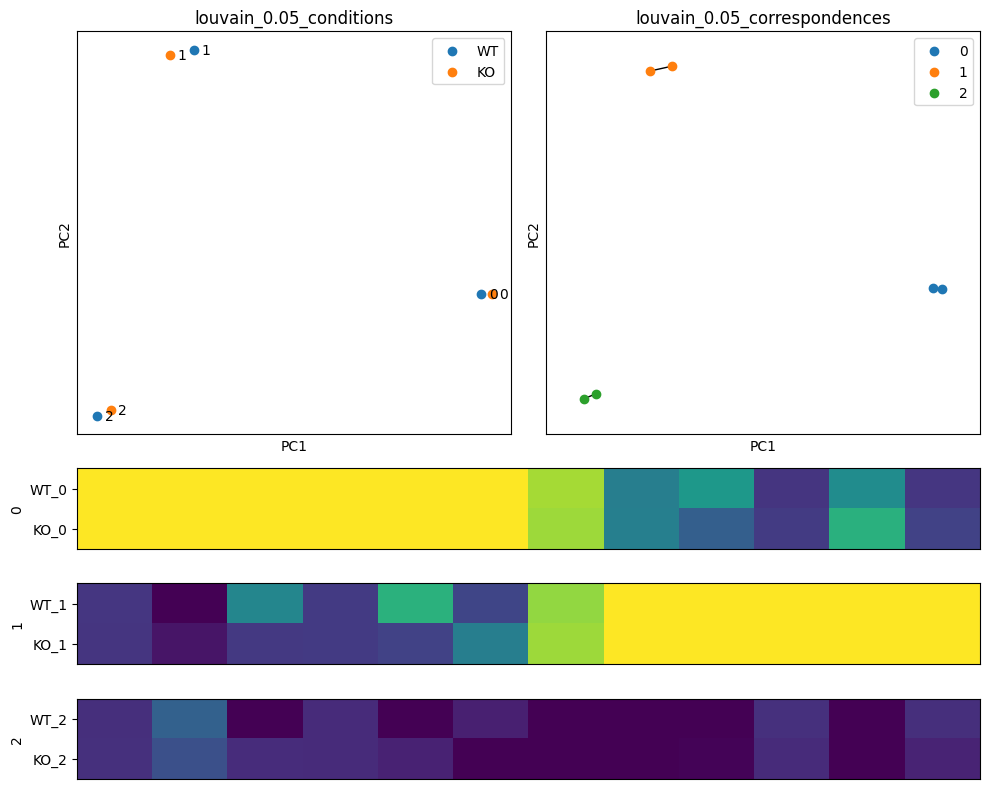

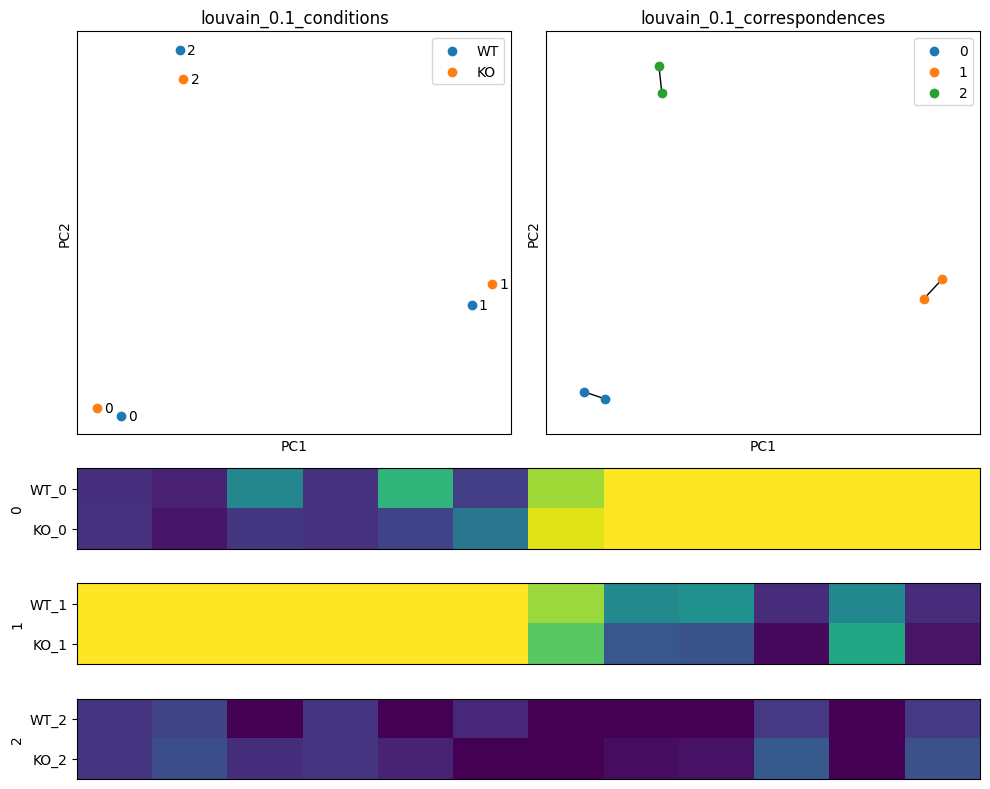

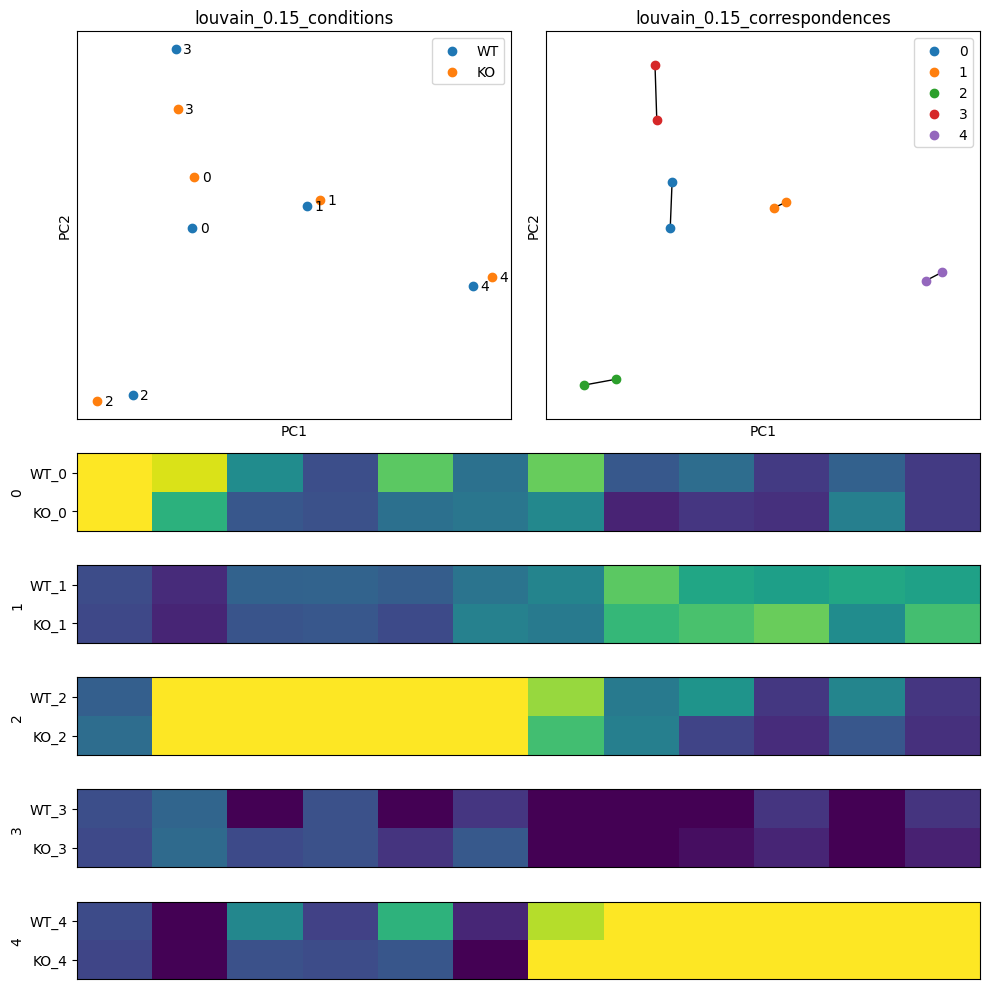

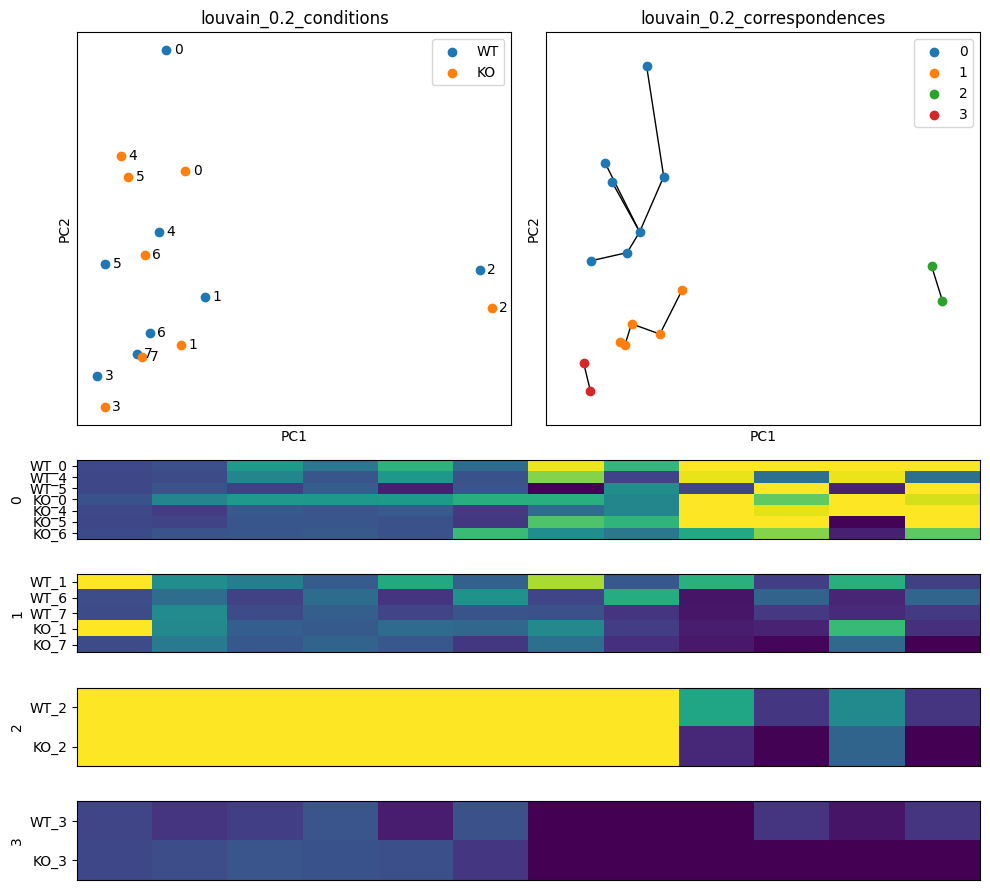

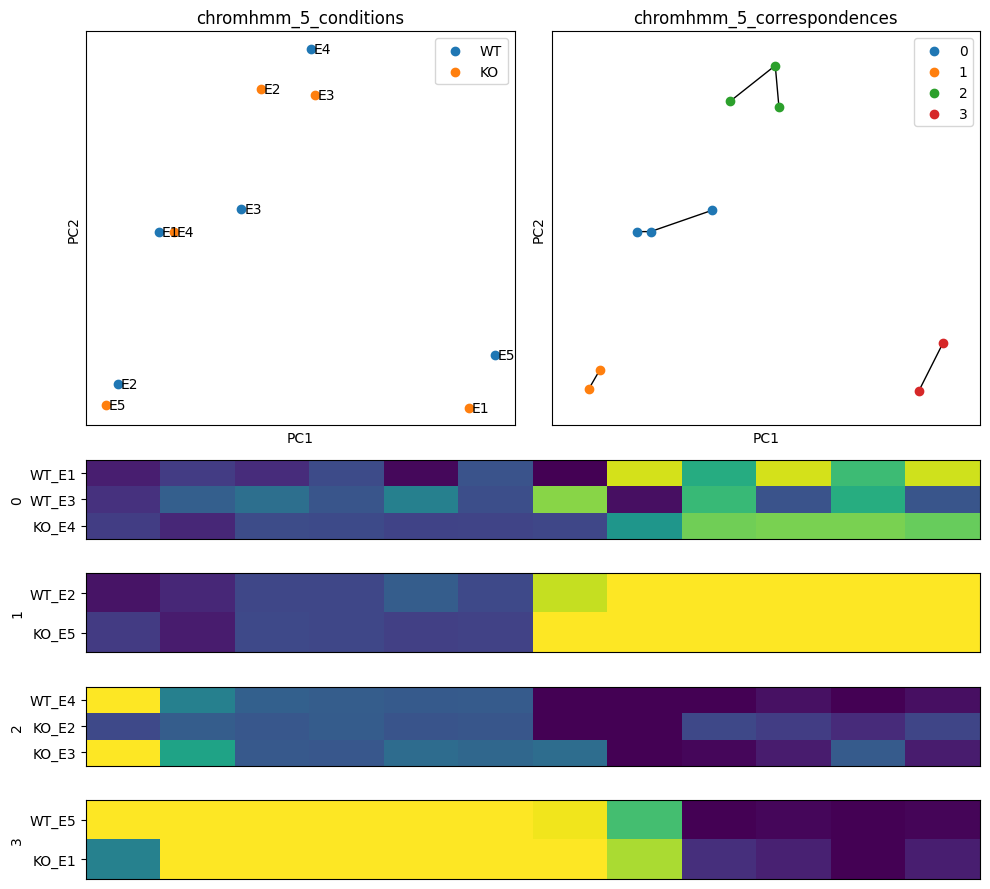

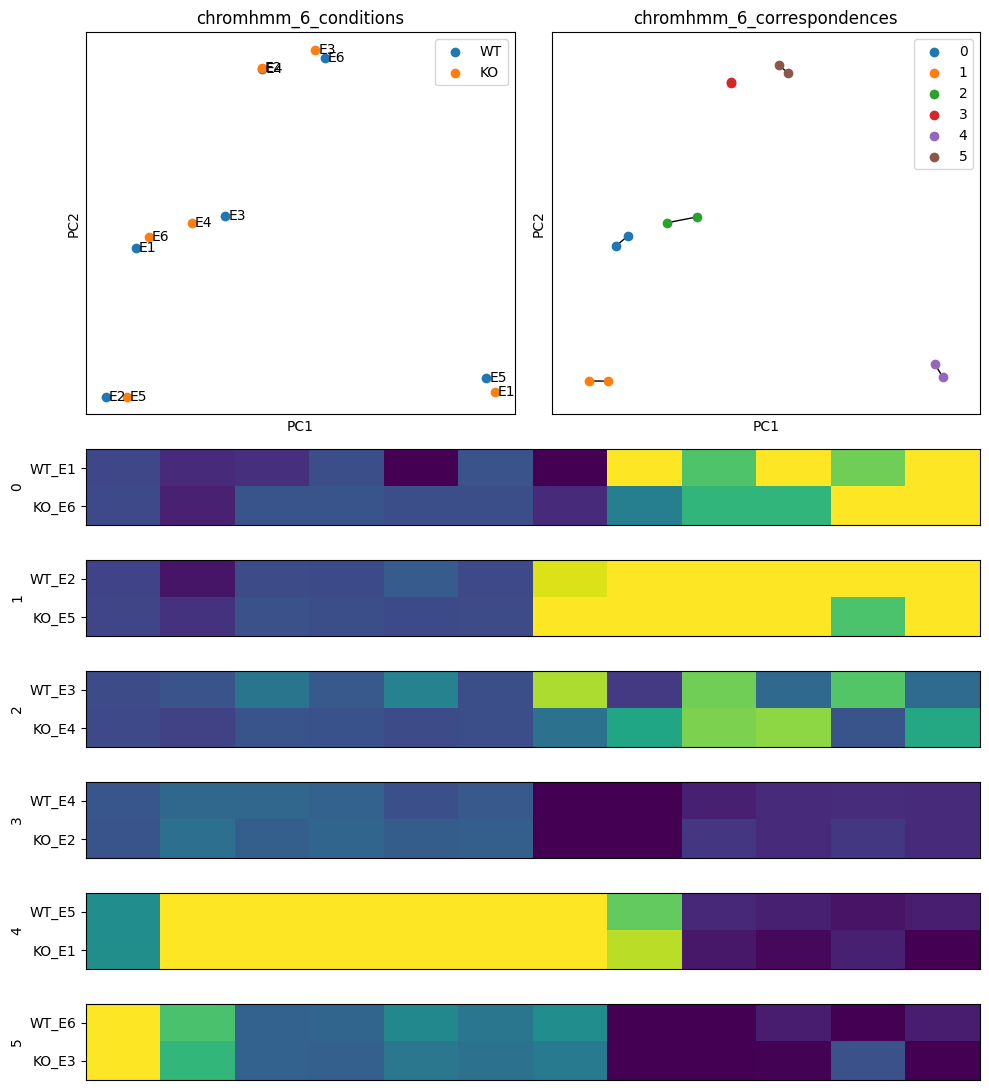

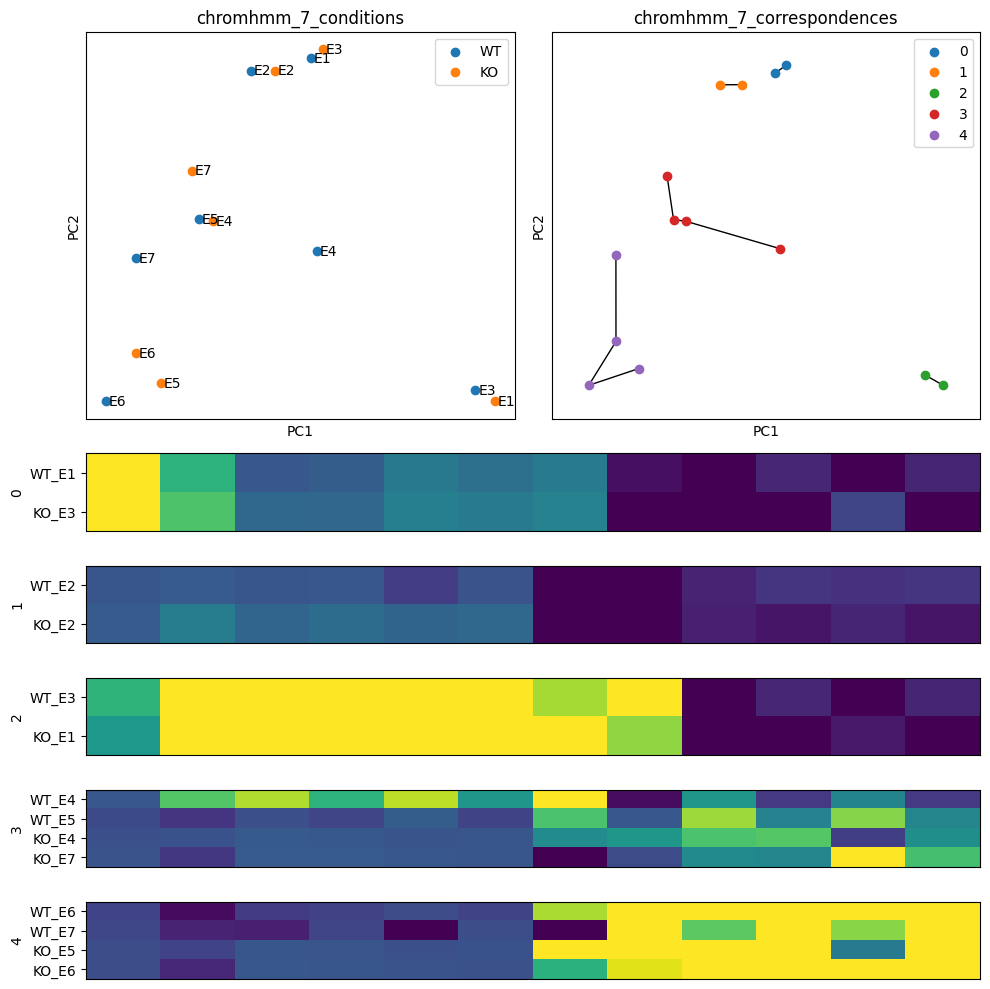

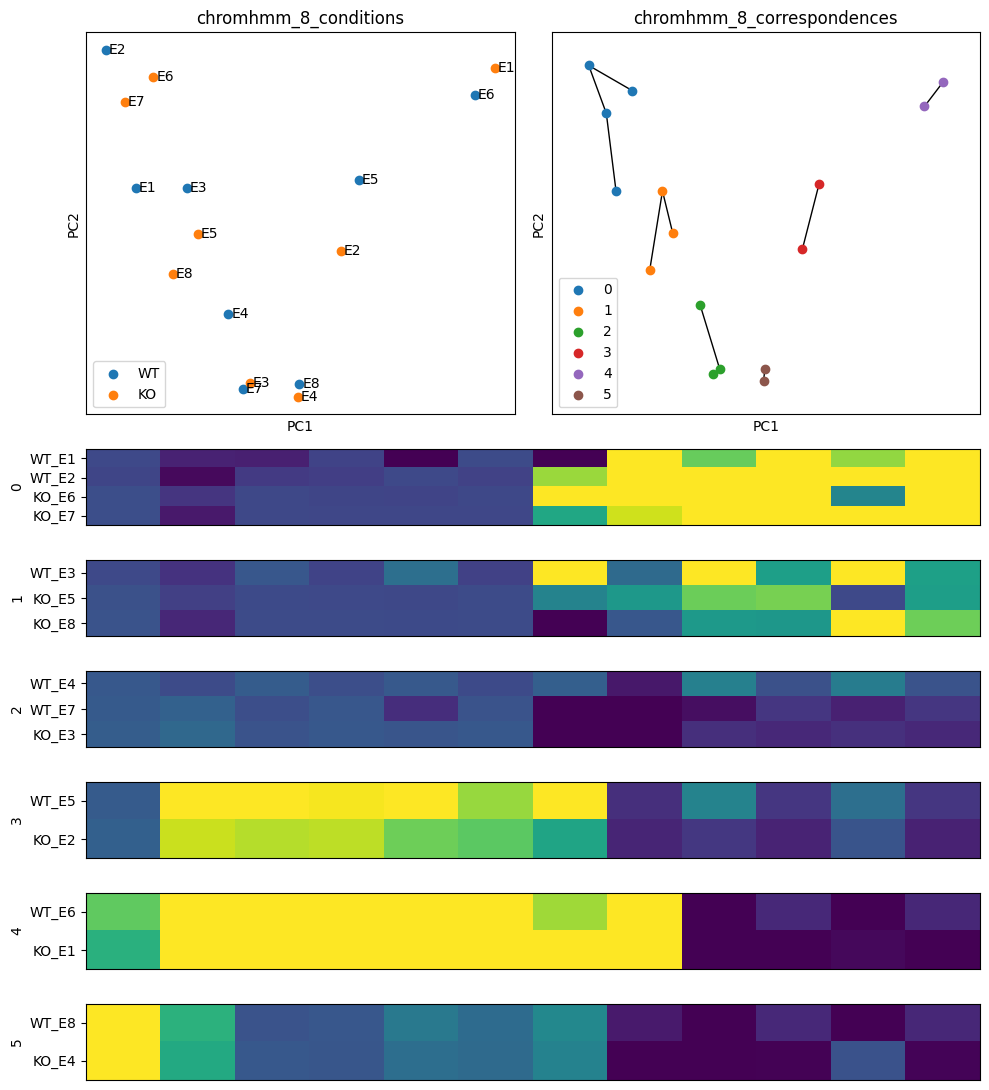

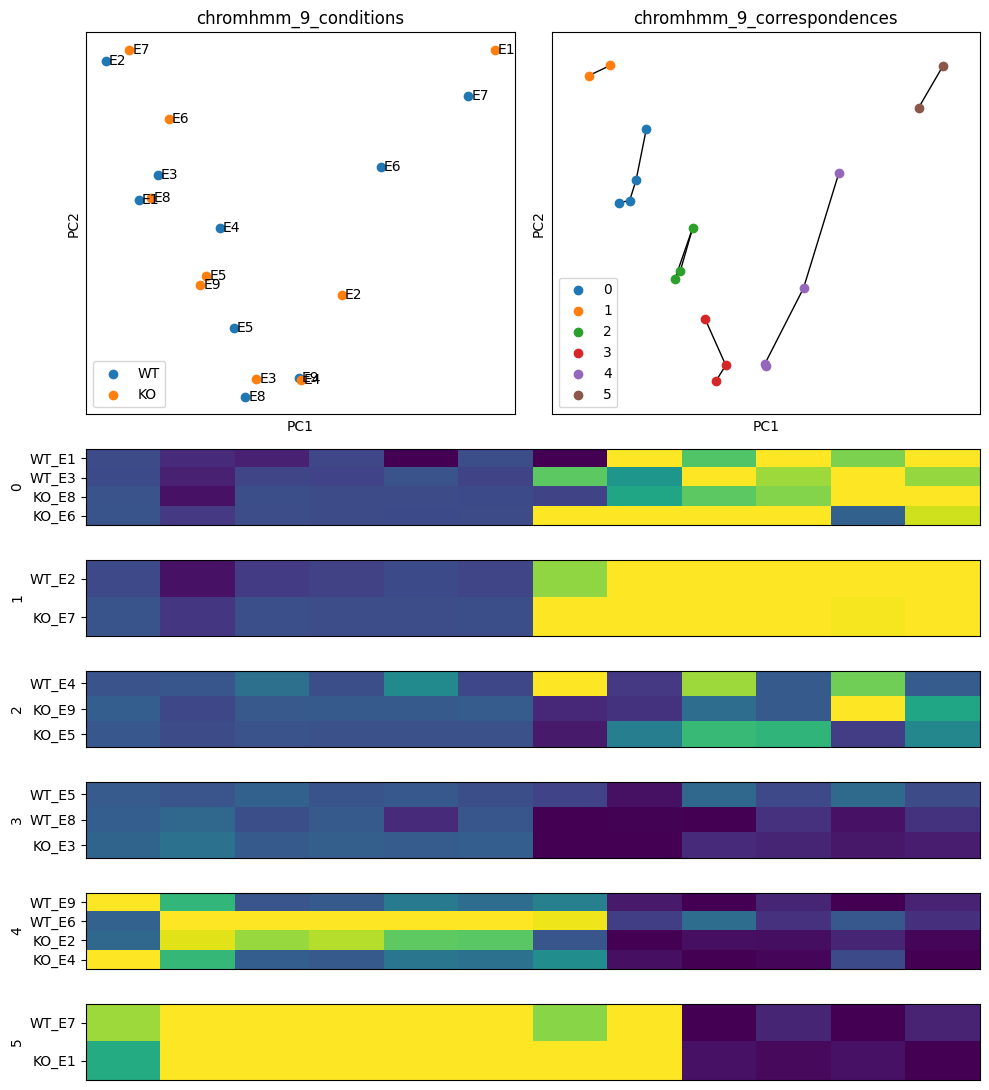

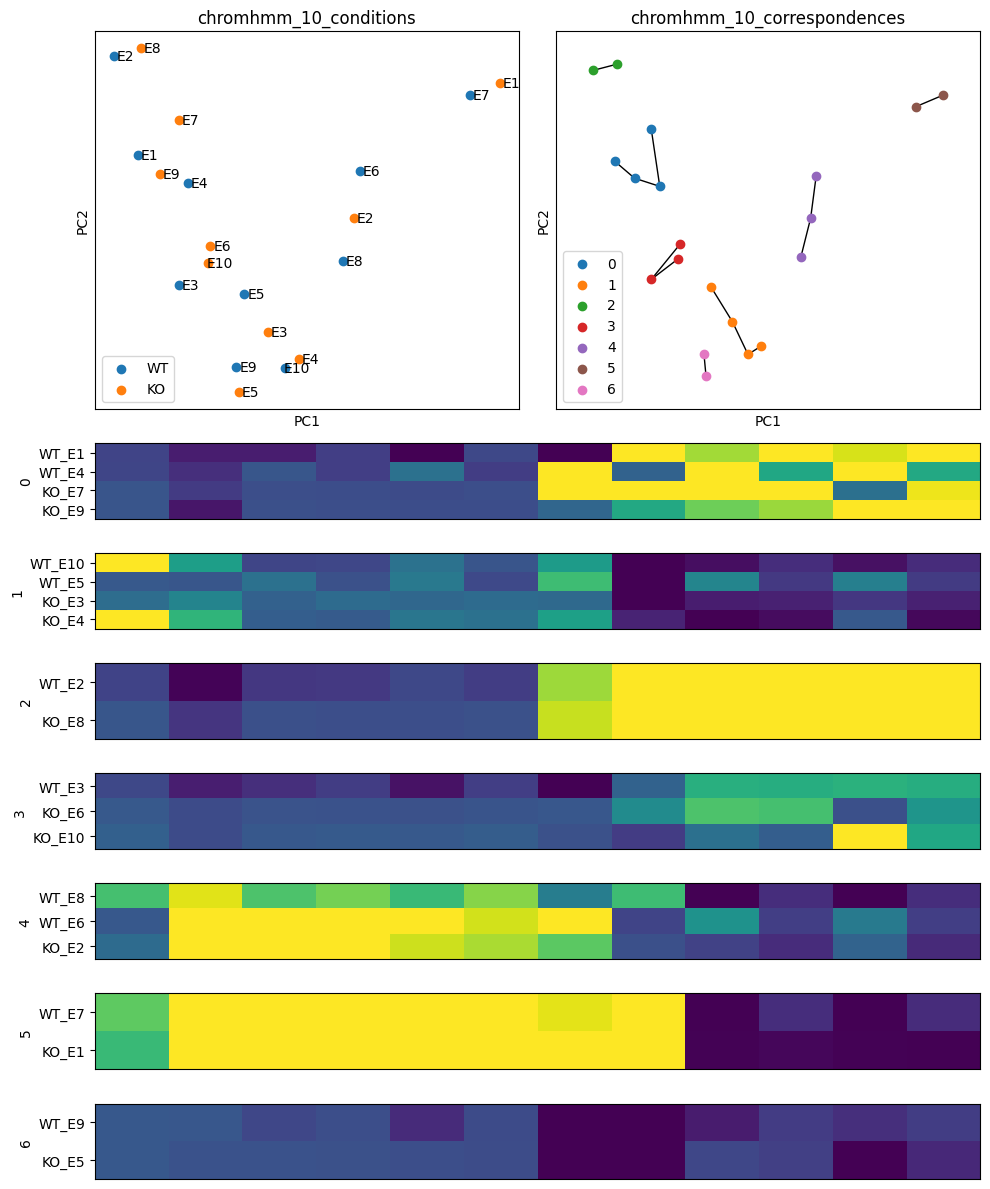

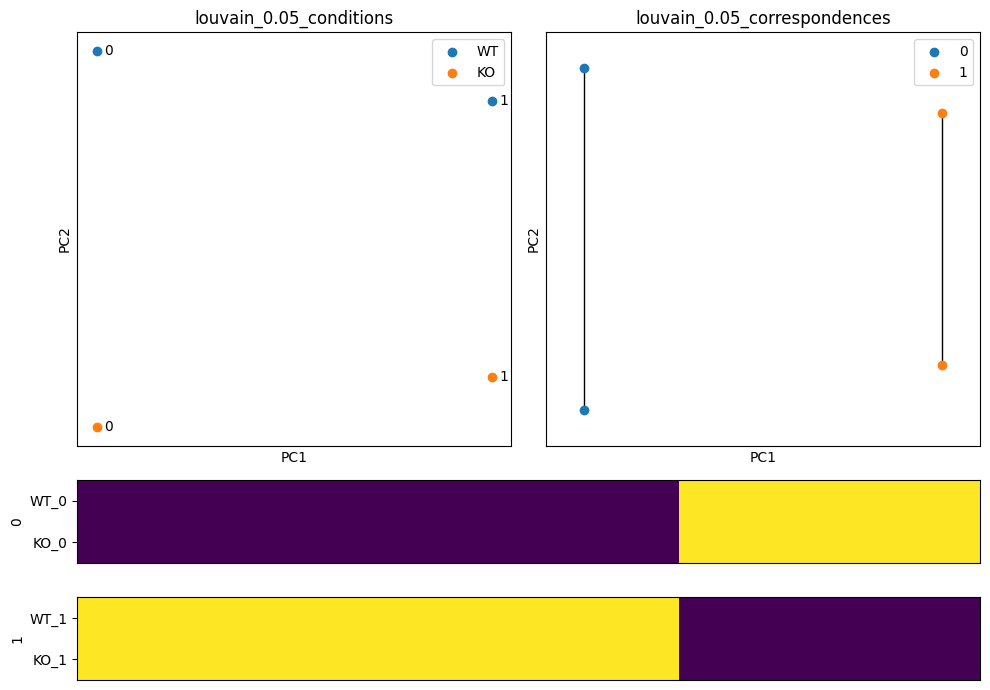

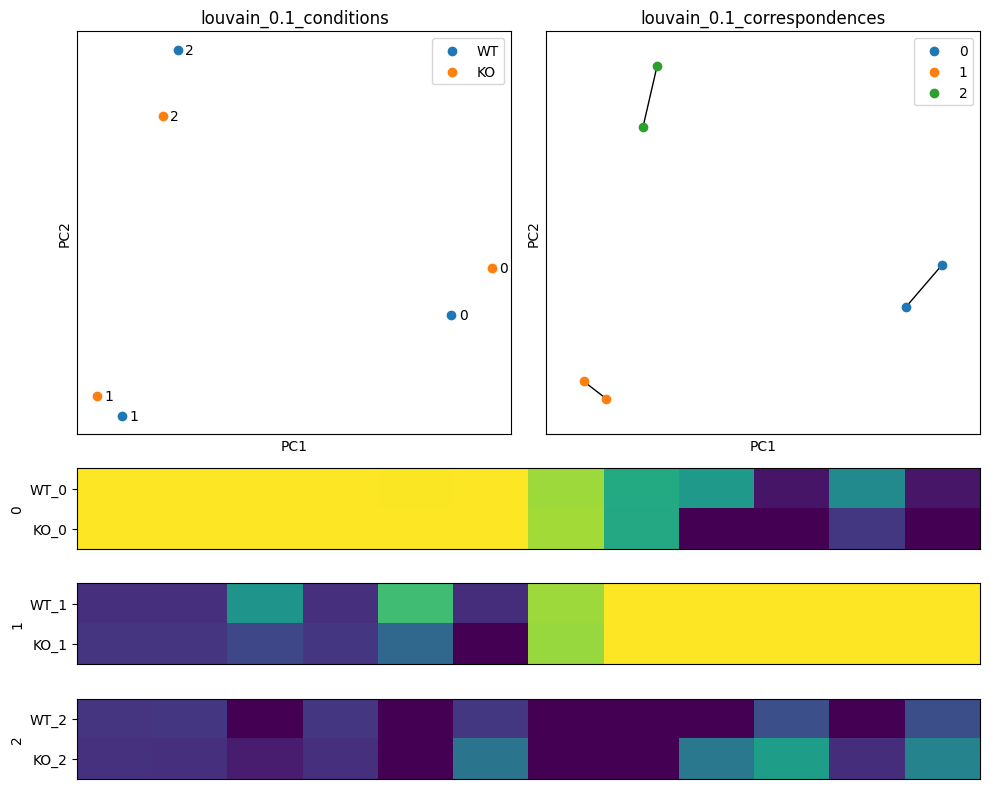

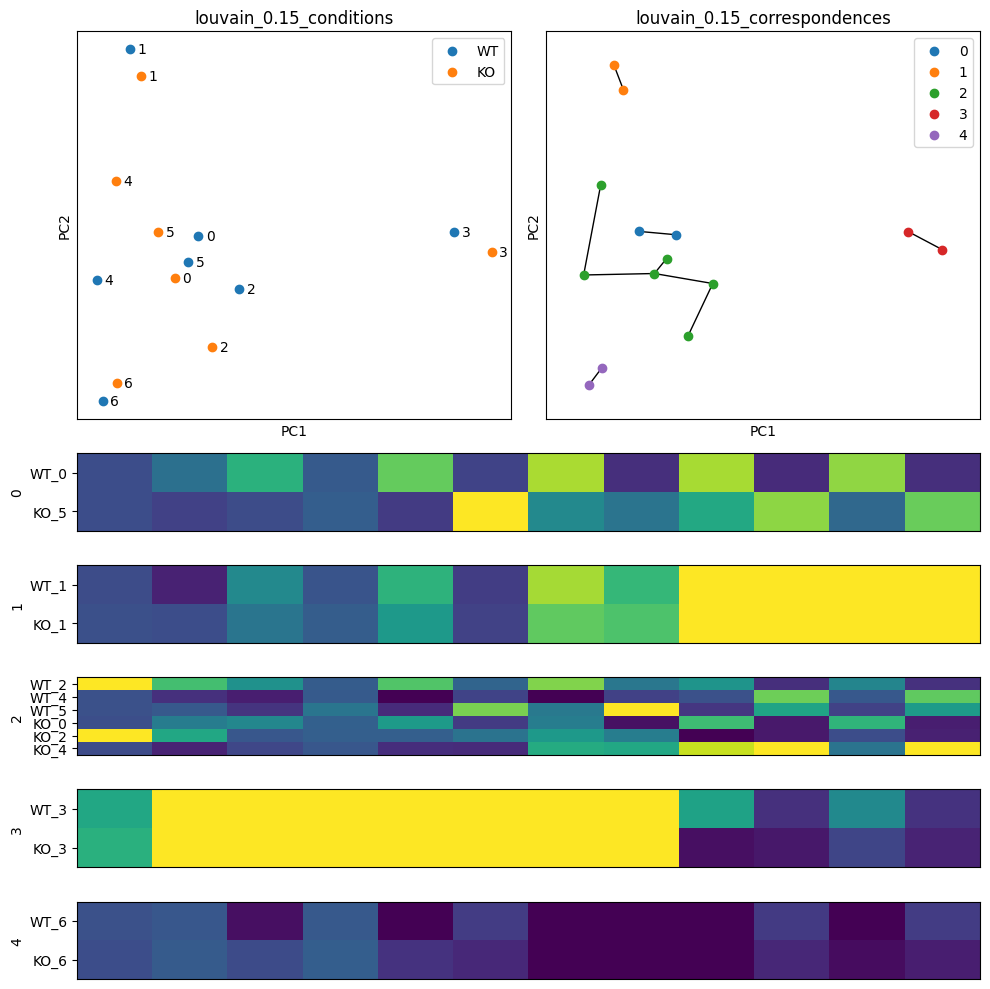

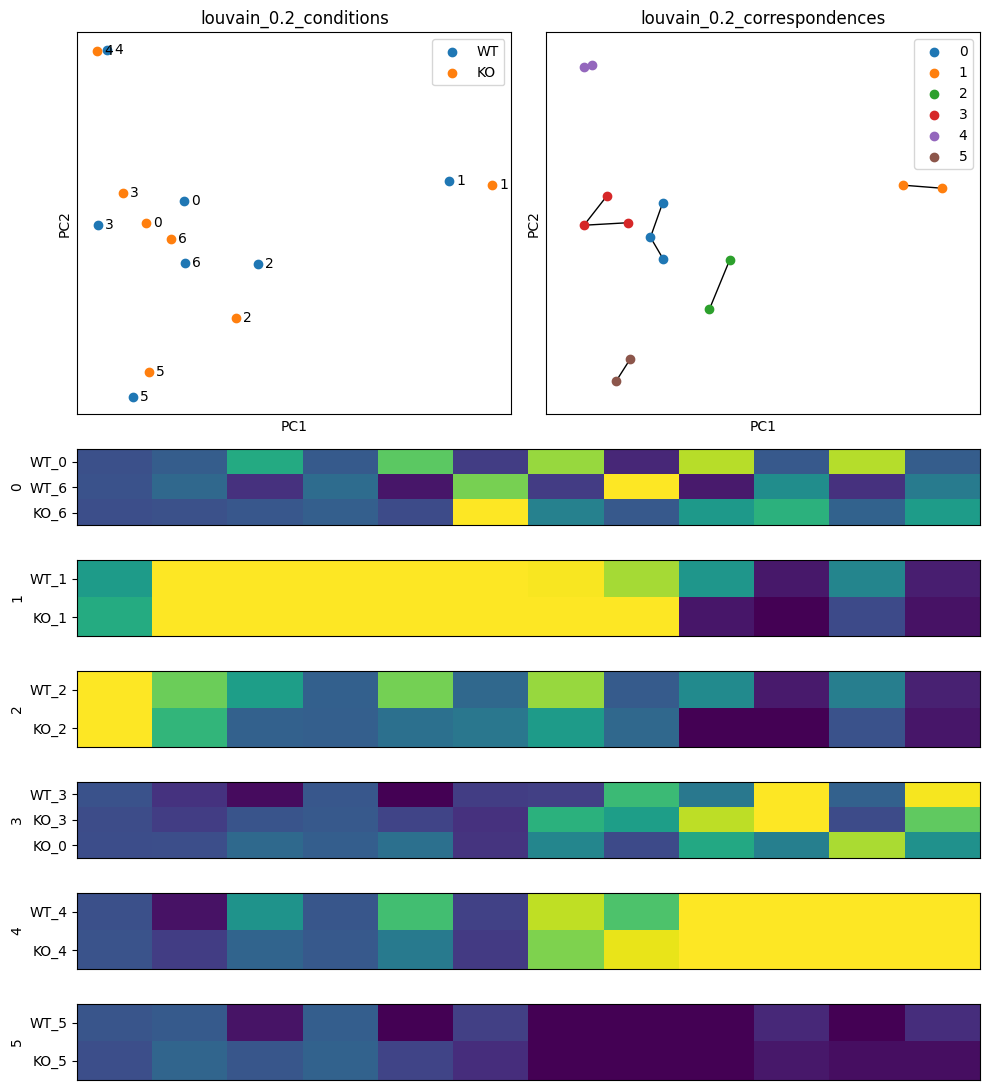

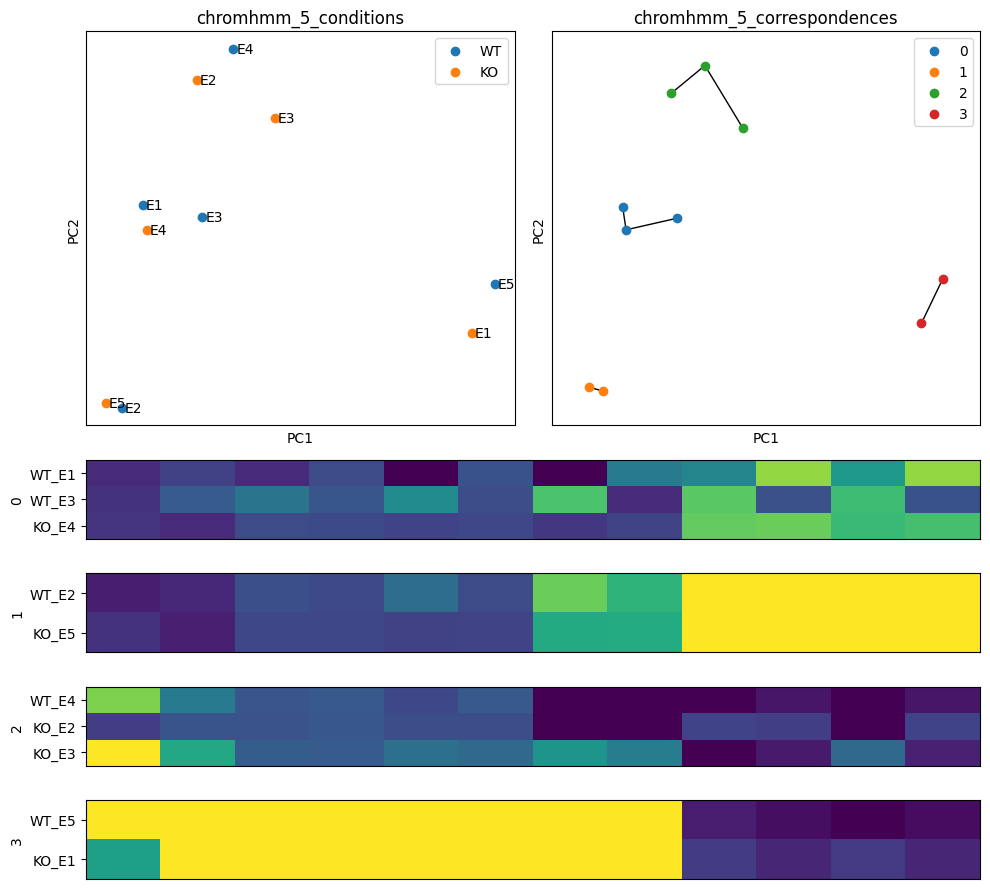

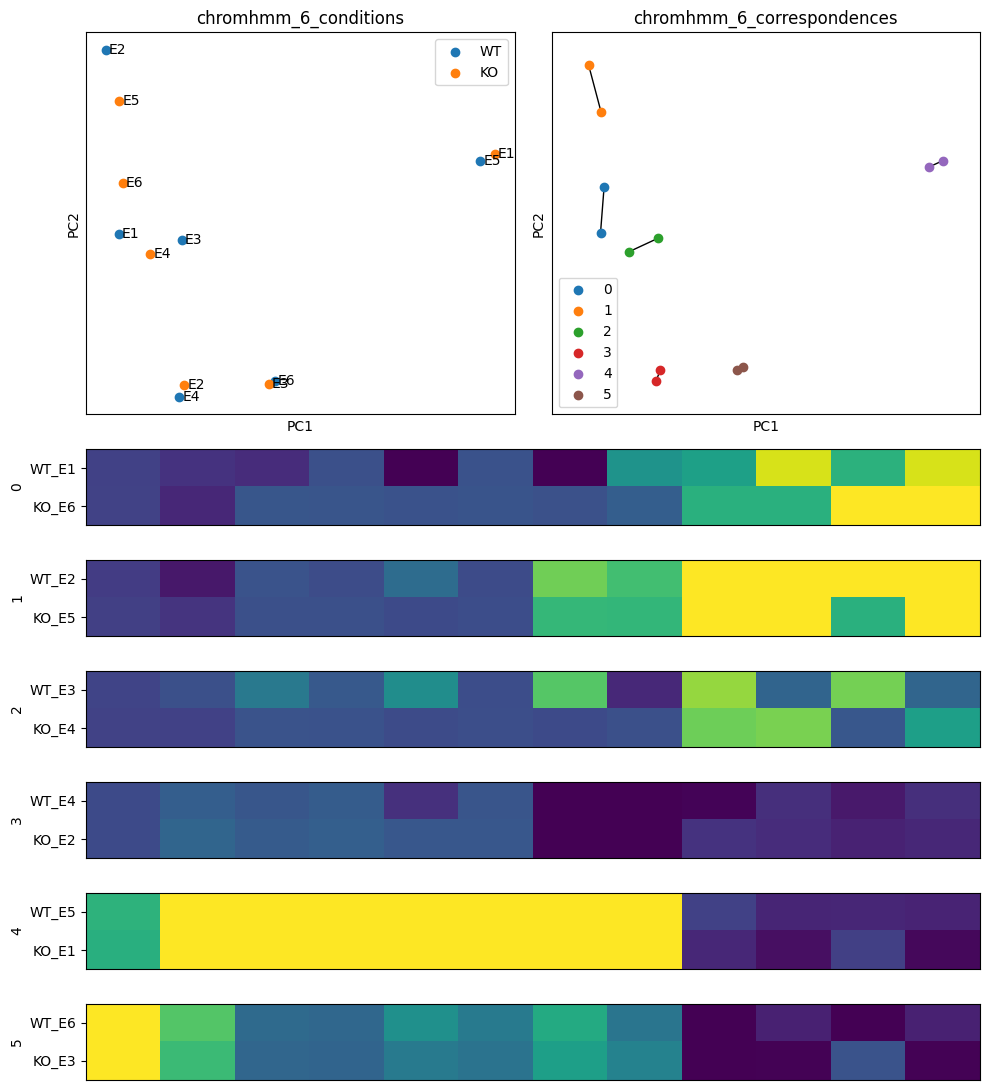

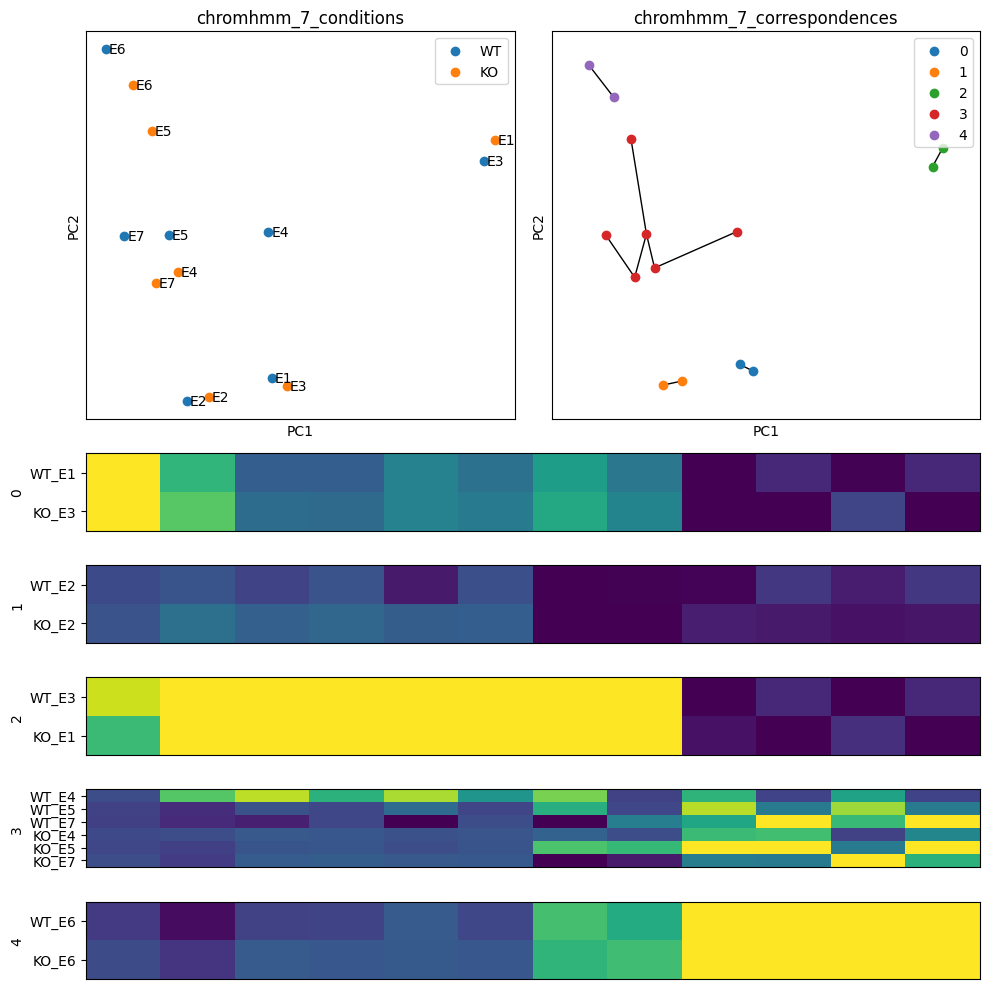

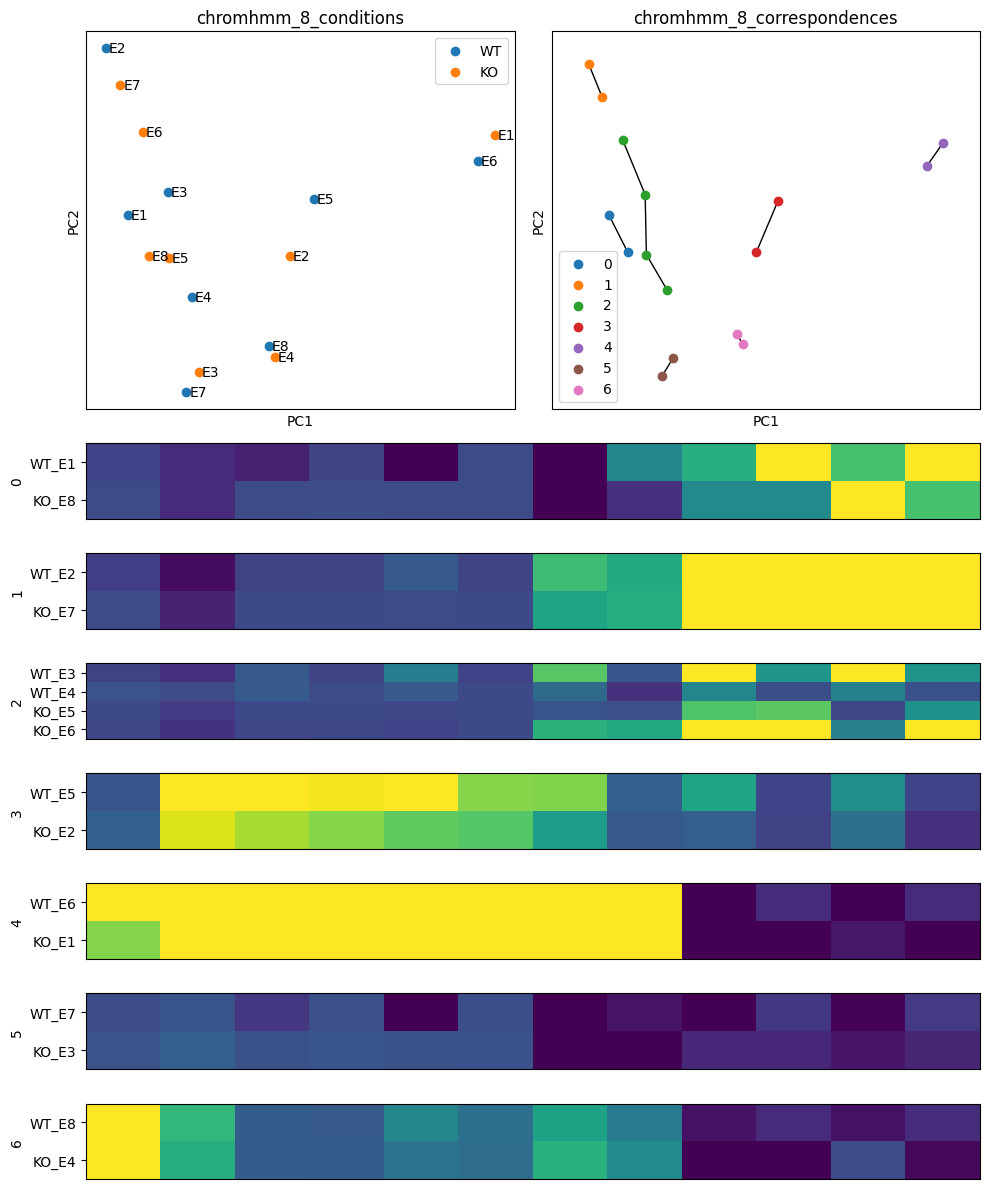

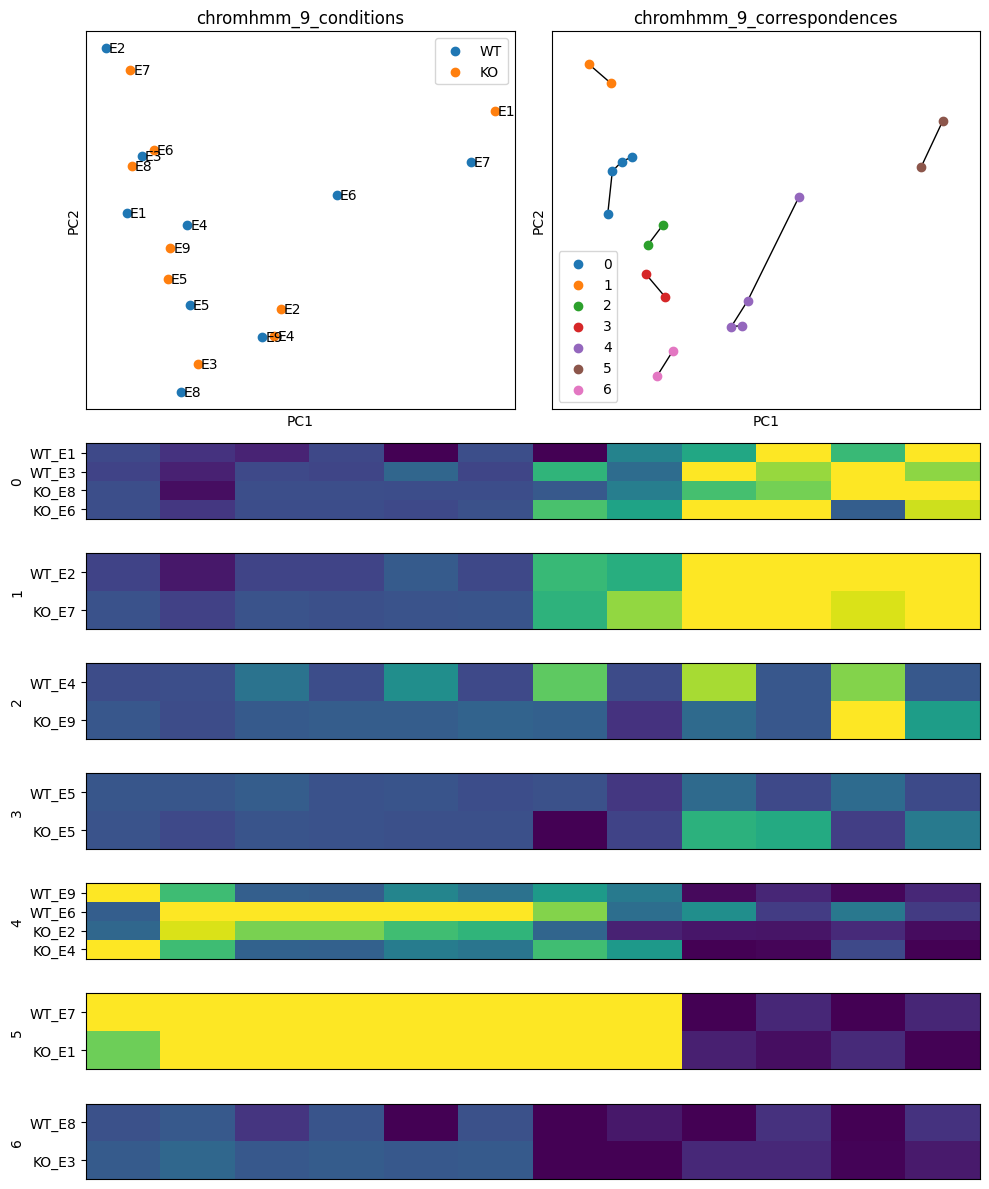

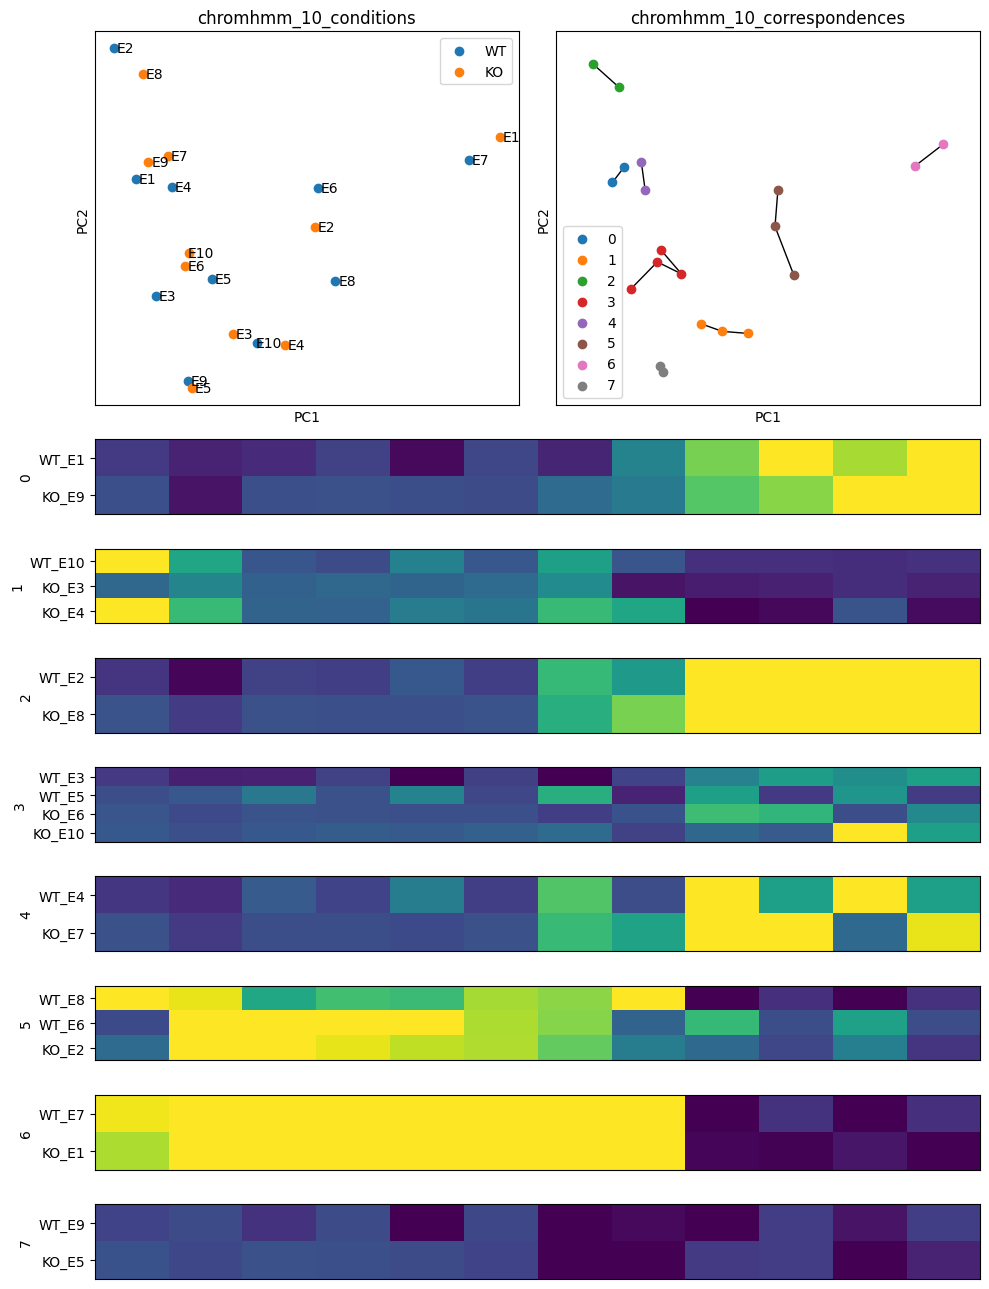

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from laminatools import align, plot

np.random.seed(1094)


for stringency in stringencies:
    for clustering_label, cluster_dict_wt in enrichments['WT'][stringency].items():
        print(stringency, clustering_label)
        cluster_dict_ko = enrichments['KO'][stringency][clustering_label]

        matrix_wt = cluster_dict_wt['matrix']
        cluster_labels_wt = np.array(cluster_dict_wt['row_names'])
        data_labels_wt = cluster_dict_wt['col_names']
        matrix_ko = cluster_dict_ko['matrix']
        cluster_labels_ko = np.array(cluster_dict_ko['row_names'])
        data_labels_ko = cluster_dict_ko['col_names']

        p1, p2, graph, correspondences = align.nearest_neighbour_correspondence(
            matrix_wt, 
            matrix_ko
        )

        fig = plt.figure()
        gs = gridspec.GridSpec(
            len(correspondences) + 1, 2,
            height_ratios = [5] + [1] * len(correspondences)
        )

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        plot.make_diagnostic_plot(
            p1, p2, graph, 
            correspondences, 
            cluster_labels_wt, 
            cluster_labels_ko, 
            'WT', 'KO',
            (ax1, ax2)
        )
        ax1.set_title(f'{clustering_label}_conditions')
        ax2.set_title(f'{clustering_label}_correspondences')

        plot.plot_recluster_data(
            correspondences,
            matrix_wt,
            matrix_ko,
            cluster_labels_wt,
            cluster_labels_ko,
            'WT', 'KO',
            gs,
            fig
        )

        fig.set_figwidth(10)
        fig.set_figheight(5 + len(correspondences))
        fig.tight_layout()
        fig.savefig(f'../plots/genome_clustercorrespondence_diagnostic_{clustering_label}_{stringency}_lap2enriched.pdf')

# Align clusters and datacolumns between conditions

In [8]:
conditions = ['WT', 'KO']
embeddings_new = {condition: {} for condition in conditions}
for stringency in stringencies:
    embedding_wt = embeddings['WT'][stringency].copy()
    embedding_ko = embeddings['KO'][stringency].copy()
    for clustering_label, cluster_dict_wt in enrichments['WT'][stringency].items():
        print(clustering_label)
        cluster_dict_ko = enrichments['KO'][stringency][clustering_label]

        matrix_wt = cluster_dict_wt['matrix']
        cluster_labels_wt = np.array(cluster_dict_wt['row_names'])
        data_labels_wt = cluster_dict_wt['col_names']

        matrix_ko = cluster_dict_ko['matrix']
        cluster_labels_ko = np.array(cluster_dict_ko['row_names'])
        data_labels_ko = cluster_dict_ko['col_names']

        p1, p2, graph, correspondences = align.nearest_neighbour_correspondence(
            matrix_wt, 
            matrix_ko
        )

        for new_cluster_label, correspondence in correspondences.items():
            wt_idx = correspondence['p1_idx']
            ko_idx = correspondence['p2_idx']

            for embedding, old_cluster_labels in zip(
                [embedding_wt, embedding_ko], 
                [cluster_labels_wt[wt_idx], cluster_labels_ko[ko_idx]]
            ):
                embedding.loc[embedding[clustering_label].isin(old_cluster_labels), clustering_label] = 'c' + str(new_cluster_label)
    
    for condition, embedding in zip(conditions, [embedding_wt, embedding_ko]):
        embeddings_new[condition][stringency] = embedding

louvain_0.05
louvain_0.1
louvain_0.15
louvain_0.2
chromhmm_5
chromhmm_6
chromhmm_7
chromhmm_8
chromhmm_9
chromhmm_10
louvain_0.05
louvain_0.1
louvain_0.15
louvain_0.2
chromhmm_5
chromhmm_6
chromhmm_7
chromhmm_8
chromhmm_9
chromhmm_10


In [9]:
from laminatools import vectorize

# recompute enrichments and correlations
correlations_new = {}
enrichments_new = {}
for condition in conditions:
    condition_correlations = {}
    condition_enrichments = {}
    for stringency in stringencies:
        print(condition, stringency)
        # don't need to log again since we already did above
        df = embeddings_new[condition][stringency]
        
        data_columns = np.array(ordered_data_columns[condition])
        cluster_columns = df.columns[
            ~df.columns.isin(['UMAP1', 'UMAP2']) &
            ~df.columns.isin(data_columns) |
            df.columns.isin(['louvain']) &
            df.columns.str.startswith('chromhmm')
        ]
        condition_correlations[stringency] = vectorize.data_correlation_over_clusterings(
            df,
            cluster_columns,
            data_columns
        )
        condition_enrichments[stringency] = vectorize.data_enrichment_over_clusterings(
            df,
            cluster_columns,
            data_columns
        )

    correlations_new[condition] = condition_correlations
    enrichments_new[condition] = condition_enrichments

correlations_new['WT']['normal']

WT normal
WT stringent
KO normal
KO stringent


{'louvain_0.05': {'matrix': array([[ 0.38475124,  0.64558982,  0.38757811,  0.39863192,  0.31316835,
           0.27719339,  0.00845773, -0.17511401, -0.59123336, -0.83524731,
          -0.62865574, -0.83204099],
         [-0.38283571, -0.6461063 , -0.38037379, -0.39597555, -0.30519779,
          -0.27453898, -0.00128987,  0.17708311,  0.5988703 ,  0.8396505 ,
           0.63610104,  0.83646116],
         [-0.01771797,  0.00811289, -0.07135372, -0.02517111, -0.07945742,
          -0.0256918 , -0.07267151, -0.02075362, -0.08009927, -0.04838316,
          -0.07832196, -0.04854108]]),
  'row_names': ['c0', 'c1', 'c2'],
  'col_names': array(['rnaseq_WT', 'atacseq_WT', 'chipseq_BRG1_WT_16',
         'chipseq_BRG1_WT_20', 'chipseq_CHD4_WT_16', 'chipseq_CHD4_WT_20',
         'chipseq_LAP2alpha_WT_16', 'chipseq_LAP2alpha_WT_20',
         'chipseq_laminA_E1_WT_16', 'chipseq_laminA_E1_WT_20',
         'chipseq_laminA_3A6_WT_16', 'chipseq_laminA_3A6_WT_20'],
        dtype='<U24')},
 'louvain_0.1'

## Change cluster ordering

normal
stringent


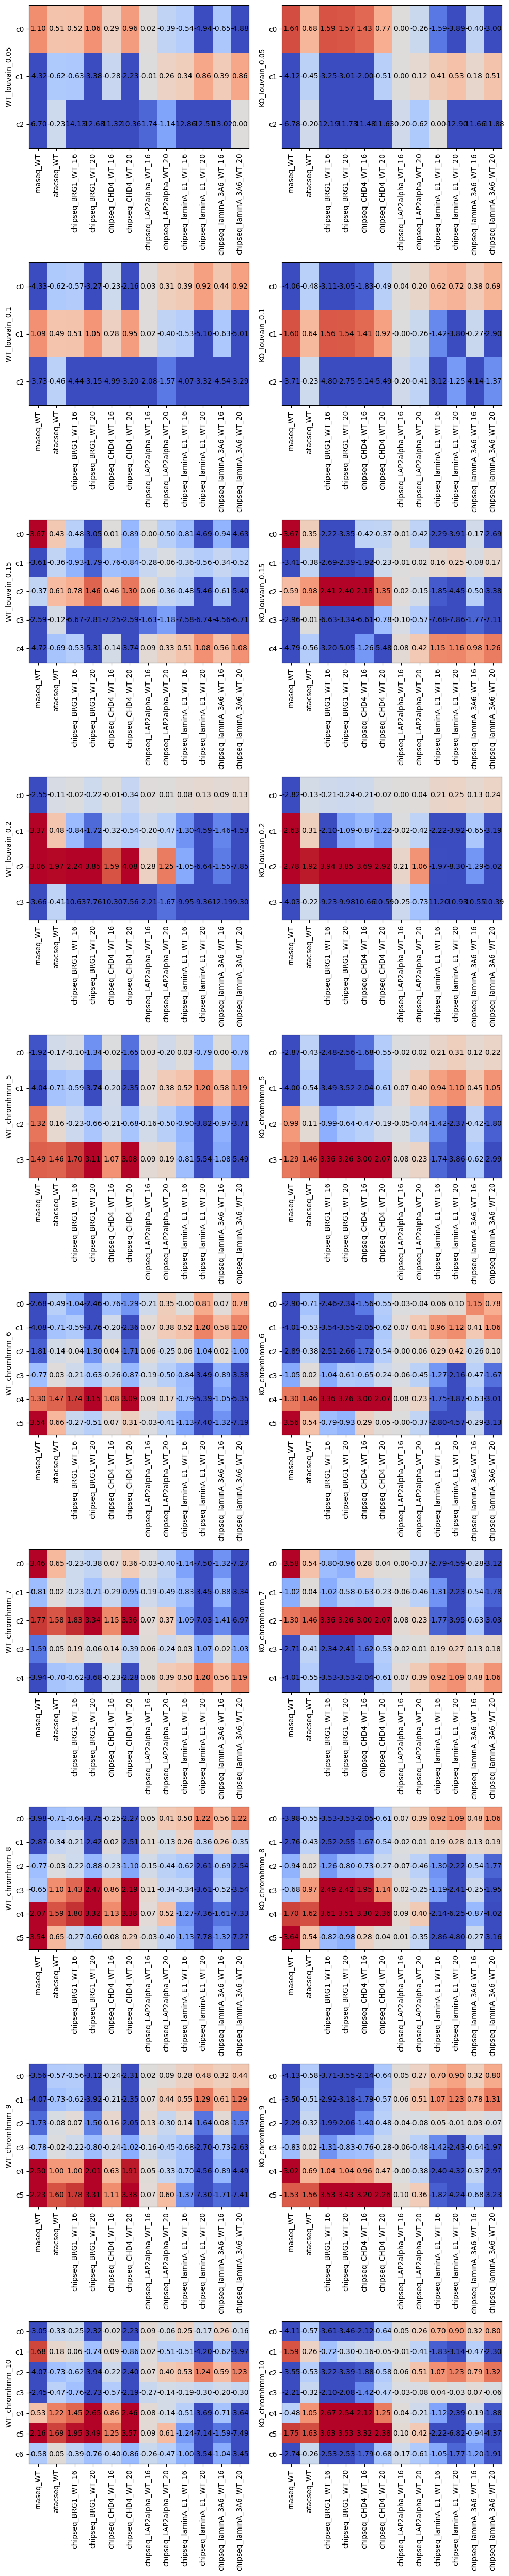

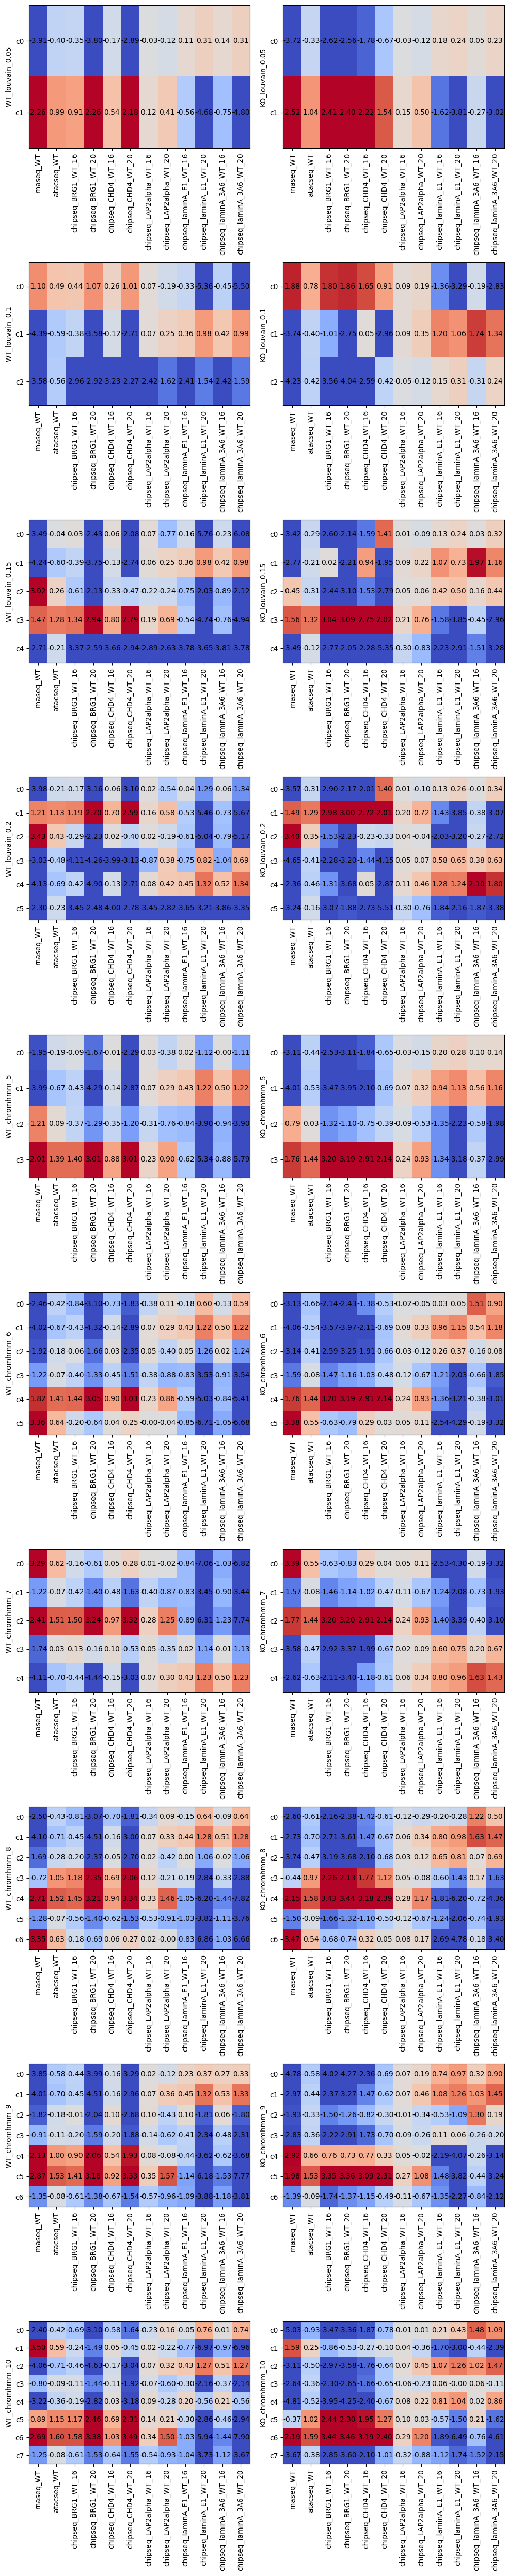

In [10]:
from copy import deepcopy

for stringency in stringencies:
    print(stringency)
    fig, axs = plt.subplots(
        len(enrichments_new['WT'][stringency]),
        len(enrichments_new)
    )
    for col_axs, (condition, condition_enrichments) in zip(
        axs.T, 
        enrichments_new.items()
    ):
        for ax, (cluster_column, signal_enrichment) in zip(
            col_axs, 
            condition_enrichments[stringency].items()
        ):
            plot.plot_matrix(
                signal_enrichment['matrix'], 
                signal_enrichment['row_names'], 
                ordered_data_columns['WT'], 
                ax = ax, 
                vmin = -2,
                vmax = 2
            )
            ax.set_ylabel(f'{condition}_{cluster_column}')

    fig.set_figwidth(10)
    fig.set_figheight(5 * len(enrichments_new['WT'][stringency]))
    fig.tight_layout()

normal
WT louvain_0.05
WT louvain_0.1
WT louvain_0.15
WT louvain_0.2
WT chromhmm_5
WT chromhmm_6
WT chromhmm_7
WT chromhmm_8
WT chromhmm_9
WT chromhmm_10
KO louvain_0.05
KO louvain_0.1
KO louvain_0.15
KO louvain_0.2
KO chromhmm_5
KO chromhmm_6
KO chromhmm_7
KO chromhmm_8
KO chromhmm_9
KO chromhmm_10
stringent
WT louvain_0.05
WT louvain_0.1
WT louvain_0.15
WT louvain_0.2
WT chromhmm_5
WT chromhmm_6
WT chromhmm_7
WT chromhmm_8
WT chromhmm_9
WT chromhmm_10
KO louvain_0.05
KO louvain_0.1
KO louvain_0.15
KO louvain_0.2
KO chromhmm_5
KO chromhmm_6
KO chromhmm_7
KO chromhmm_8
KO chromhmm_9
KO chromhmm_10


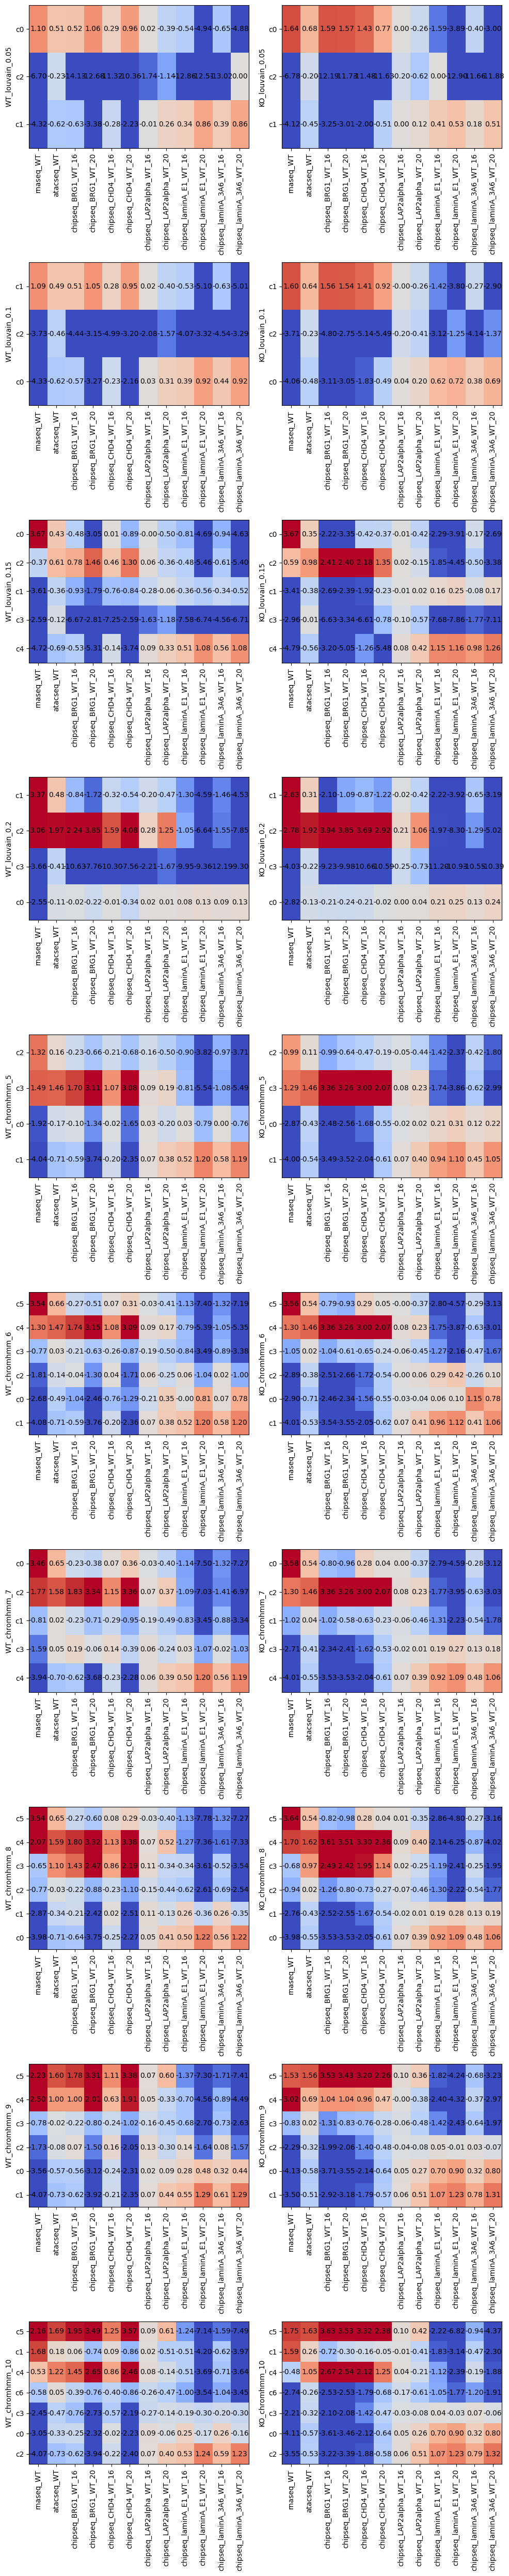

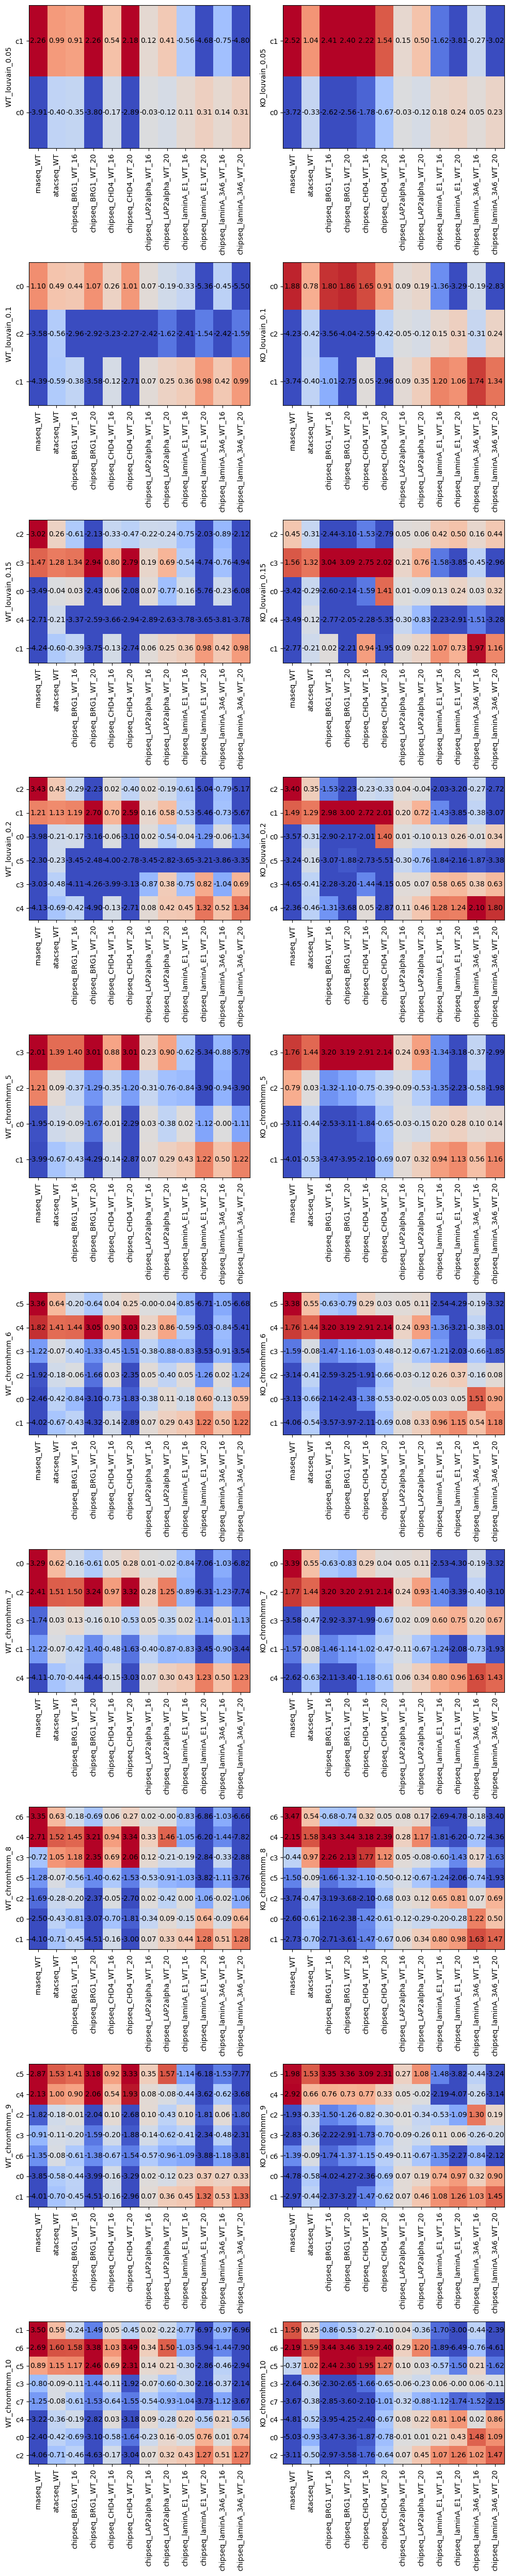

In [14]:
sort_indexes = {
    'stringent': {
        'louvain_0.05': [1, 0],
        'louvain_0.1': [0, 2, 1],
        'louvain_0.15': [2, 3, 0, 4, 1],
        'louvain_0.2': [2, 1, 0, 5, 3, 4],
        'chromhmm_5': [3, 2, 0, 1],
        'chromhmm_6': [5, 4, 3, 2, 0, 1],
        'chromhmm_7': [0, 2, 3, 1, 4],
        'chromhmm_8': [6, 4, 3, 5, 2, 0, 1],
        'chromhmm_9': [5, 4, 2, 3, 6, 0, 1],
        'chromhmm_10': [1, 6, 5, 3, 7, 4, 0, 2]
    },
    'normal': {
        'louvain_0.05': [0, 2, 1],
        'louvain_0.1': [1, 2, 0],
        'louvain_0.15': [0, 2, 1, 3, 4],
        'louvain_0.2': [1, 2, 3, 0],
        'chromhmm_5': [2, 3, 0, 1],
        'chromhmm_6': [5, 4, 3, 2, 0, 1],
        'chromhmm_7': [0, 2, 1, 3, 4],
        'chromhmm_8': [5, 4, 3, 2, 1, 0],
        'chromhmm_9': [5, 4, 3, 2, 0, 1],
        'chromhmm_10': [5, 1, 4, 6, 3, 0, 2]
    }
}

for stringency in stringencies:
    print(stringency)
    fig, axs = plt.subplots(
        len(enrichments_new['WT'][stringency]),
        len(enrichments_new)
    )
    for col_axs, (condition, condition_enrichments) in zip(
        axs.T, 
        enrichments_new.items()
    ):
        for ax, (cluster_column, signal_enrichment) in zip(
            col_axs, 
            condition_enrichments[stringency].items()
        ):
            print(condition, cluster_column)
            sort_index = sort_indexes[stringency][cluster_column]
            plot.plot_matrix(
                signal_enrichment['matrix'][sort_index, :], 
                np.array(signal_enrichment['row_names'])[sort_index], 
                ordered_data_columns['WT'], 
                ax = ax, 
                vmin = -2,
                vmax = 2
            )
            ax.set_ylabel(f'{condition}_{cluster_column}')

    fig.set_figwidth(10)
    fig.set_figheight(5 * len(enrichments_new['WT'][stringency]))
    fig.tight_layout()

In [16]:
enrichments_sorted = deepcopy(enrichments_new)
correlations_sorted = deepcopy(correlations_new)
embeddings_sorted = deepcopy(embeddings_new)

for stringency in stringencies:
    for col_axs, (condition, condition_enrichments) in zip(
        axs.T, 
        enrichments_new.items()
    ):
        for ax, (cluster_column, signal_enrichment) in zip(
            col_axs, 
            condition_enrichments[stringency].items()
        ):
            print(cluster_column, condition, stringency)
            sort_index = sort_indexes[stringency][cluster_column]
            embedding = embeddings_sorted[condition][stringency]
            row_labels = np.array(
                enrichments_sorted[condition][stringency][cluster_column]['row_names']
            )
            sorted_row_labels = row_labels[sort_index]

            for signals in [enrichments_sorted, correlations_sorted]:
                signal = signals[condition][stringency][cluster_column]
                signal['matrix'] = signal['matrix'][sort_index, :]
                signal['row_names'] = ['c' + str(i) for i in range(len(sorted_row_labels))]

            old_to_new_cluster_names = {
                old_row_name: f'c{i}' for i, old_row_name in enumerate(sorted_row_labels)
            }
            embedding.loc[:, cluster_column] = embedding.loc[:, cluster_column].apply(
                lambda x: old_to_new_cluster_names[x]
            )

louvain_0.05 WT normal
louvain_0.1 WT normal
louvain_0.15 WT normal
louvain_0.2 WT normal
chromhmm_5 WT normal
chromhmm_6 WT normal
chromhmm_7 WT normal
chromhmm_8 WT normal
chromhmm_9 WT normal
chromhmm_10 WT normal
louvain_0.05 KO normal
louvain_0.1 KO normal
louvain_0.15 KO normal
louvain_0.2 KO normal
chromhmm_5 KO normal
chromhmm_6 KO normal
chromhmm_7 KO normal
chromhmm_8 KO normal
chromhmm_9 KO normal
chromhmm_10 KO normal
louvain_0.05 WT stringent
louvain_0.1 WT stringent
louvain_0.15 WT stringent
louvain_0.2 WT stringent
chromhmm_5 WT stringent
chromhmm_6 WT stringent
chromhmm_7 WT stringent
chromhmm_8 WT stringent
chromhmm_9 WT stringent
chromhmm_10 WT stringent
louvain_0.05 KO stringent
louvain_0.1 KO stringent
louvain_0.15 KO stringent
louvain_0.2 KO stringent
chromhmm_5 KO stringent
chromhmm_6 KO stringent
chromhmm_7 KO stringent
chromhmm_8 KO stringent
chromhmm_9 KO stringent
chromhmm_10 KO stringent


# Generate correspondence plots

In [23]:
from laminatools import plot, enrichment

np.random.seed(1094)

palettes = {}
this_condition, that_condition = conditions
for stringency in stringencies:
    stringency_palettes = {}
    binsize_correlations_this = correlations_sorted[this_condition][stringency]
    binsize_correlations_that = correlations_sorted[that_condition][stringency]
    binsize_enrichments_this = enrichments_sorted[this_condition][stringency]
    binsize_enrichments_that = enrichments_sorted[that_condition][stringency]

    this_data = embeddings_sorted[this_condition][stringency]
    that_data = embeddings_sorted[that_condition][stringency]

    for clustering in binsize_correlations_this.keys():
        colors = plot.get_categorical_colors(
            binsize_enrichments_this[clustering]['row_names']
        )
        stringency_palettes[clustering] = colors
        palette = {
            f'{i+1}_{condition}': colors for i, condition in enumerate(conditions)
        }
        plot.plot_cluster_correspondence(
            binsize_correlations_this,
            binsize_correlations_that,
            this_data,
            that_data,
            clustering,
            this_condition,
            that_condition,
            f'../plots/clustercorrespondence_correlation_{clustering}_{stringency}_lap2enriched_all.pdf',
            vmin = -1,
            vmax = 1,
            palette = palette
        )

        plot.plot_cluster_correspondence(
            binsize_enrichments_this,
            binsize_enrichments_that,
            this_data,
            that_data,
            clustering,
            this_condition,
            that_condition,
            f'../plots/clustercorrespondence_enrichment_{clustering}_{stringency}_lap2enriched_all.pdf',
            vmin = -2,
            vmax = 2,
            palette = palette
        )
    
    palettes[stringency] = stringency_palettes

# Plot realigned umap

In [24]:
import matplotlib.pyplot as plt
    
n_panels_per_row = 4
for stringency in stringencies:
    for condition, binsize_embeddings in embeddings_sorted.items():
        print(f'{condition}_{stringency}')
        embedding = binsize_embeddings[stringency]
        embedding.to_hdf(
            f'../embeddings_genome_lap2enriched.aligned.h5',
            f'{condition}_{stringency}',
            mode = 'a'
        )
        cluster_column_index = embedding.columns.str.startswith('louvain') | embedding.columns.str.startswith('chromhmm')
        cluster_columns = embedding.columns[cluster_column_index].to_list()
        data_columns = ordered_data_columns[condition]

        annotation_columns = cluster_columns + data_columns

        plot.plot_and_save_annotated_embedding(
            embedding,
            annotation_columns,
            f'../plots/genome_umap_{condition}_{stringency}.aligned.png',
            plot_per_category = True,
            palettes = palettes[stringency]
        )

WT_normal
KO_normal
WT_stringent
KO_stringent
